In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df_in = pd.read_csv('/content/drive/MyDrive/Ensemble_Project/AB_NYC_2019.csv')

In [ ]:
#df_in.describe()

In [ ]:
df_in.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
#AJ comments -
  #Aggregate on host_id to get multiple listings by a single host -- cross check with the calculated_host_listings column
  #Range of the listing price is skewed with values above a certain limit -- impute or normalize them
    #11 entries with price = 0
  #Room type and neighbourhoods to be encoded
  #add more parameters on demographics using the lat/long combo from public data source for NY
  #minimum_nights column -- to be explored more

In [ ]:
df_in.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
#host name & location name unavaiable in some instances -- does it matter? can we ignore?

In [ ]:
cols = ['neighbourhood_group','neighbourhood','minimum_nights','room_type','calculated_host_listings_count']

for y in cols:
  uni = df_in[y].unique()
  print(f"{y}:{uni}")

#df_in.neighbourhood_group.unique()

neighbourhood_group:['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
neighbourhood:['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason Point' 'Eastchester' 'Kingsbridge'
 'Two Bridges' 

In [ ]:
for x in df_in.columns:
  cnt = df_in[x].count()
  uni = df_in[x].nunique()
  print(f"{x} : {cnt}/{uni}")

id : 48895/48895
name : 48879/47905
host_id : 48895/37457
host_name : 48874/11452
neighbourhood_group : 48895/5
neighbourhood : 48895/221
latitude : 48895/19048
longitude : 48895/14718
room_type : 48895/3
price : 48895/674
minimum_nights : 48895/109
number_of_reviews : 48895/394
last_review : 38843/1764
reviews_per_month : 38843/937
calculated_host_listings_count : 48895/47
availability_365 : 48895/366


In [ ]:
df_in.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [ ]:
df_new = df_in.price.value_counts().rename_axis('price').reset_index(name='counts')

In [ ]:
df_new.sort_values('price').head(30)

In [ ]:
plt.hist(df_in['price'])
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices')
plt.show()

In [ ]:
df_new = df_in.minimum_nights.value_counts().rename_axis('min_nights').reset_index(name='counts')

In [ ]:
df_new.sort_values('min_nights', ascending = False).head(30)

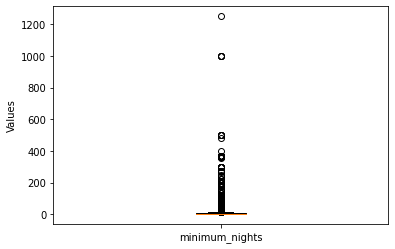

In [ ]:
columns_to_plot = ['minimum_nights']#, 'price', 'calculated_host_listings_count', 'number_of_reviews']
plt.boxplot(df_in[columns_to_plot])


plt.ylabel('Values')

plt.xticks(range(1, len(columns_to_plot) + 1), columns_to_plot)
plt.show()

In [ ]:
Q1 = df_in['price'].quantile(0.25)
Q3 = df_in['price'].quantile(0.75)
IQR = Q3 - Q1

filtered = df_in.query('(price < @Q1 - 1.5 * @IQR) or (price > @Q3 + 1.5 * @IQR)')

In [ ]:
filtered
#~6000 rows for minimum_nights with outlier values
#are values like 1 month -- 3 months still correct? to check

#~3000 rows where price appears to be outliers
#transform to other scale?? square root or log transformation

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
61,15396,Sunny & Spacious Chelsea Apartment,60278,Petra,Manhattan,Chelsea,40.74623,-73.99530,Entire home/apt,375,180,5,2018-11-03,0.12,1,180
85,19601,perfect for a family or small group,74303,Maggie,Brooklyn,Brooklyn Heights,40.69723,-73.99268,Entire home/apt,800,1,25,2016-08-04,0.24,1,7
103,23686,2000 SF 3br 2bath West Village private townhouse,93790,Ann,Manhattan,West Village,40.73096,-74.00319,Entire home/apt,500,4,46,2019-05-18,0.55,2,243
114,26933,2 BR / 2 Bath Duplex Apt with patio! East Village,72062,Bruce,Manhattan,East Village,40.72540,-73.98157,Entire home/apt,350,2,7,2017-08-09,0.06,4,298
121,27659,3 Story Town House in Park Slope,119588,Vero,Brooklyn,South Slope,40.66499,-73.97925,Entire home/apt,400,2,16,2018-12-30,0.24,2,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48758,36420289,"Rustic Garden House Apt, 2 stops from Manhattan",73211393,LaGabrell,Queens,Long Island City,40.75508,-73.93258,Entire home/apt,350,2,0,NaN,NaN,1,364
48833,36450896,Brand New 3-Bed Apt in the Best Location of FiDi,29741813,Yue,Manhattan,Financial District,40.70605,-74.01042,Entire home/apt,475,2,0,NaN,NaN,1,64
48839,36452721,Massage Spa. Stay overnight. Authors Artist dr...,274079964,Richard,Brooklyn,Sheepshead Bay,40.59866,-73.95661,Private room,800,1,0,NaN,NaN,1,23
48842,36453160,LUXURY MANHATTAN PENTHOUSE+HUDSON RIVER+EMPIRE...,224171371,LuxuryApartmentsByAmber,Manhattan,Chelsea,40.75204,-74.00292,Entire home/apt,350,1,0,NaN,NaN,1,9


In [ ]:
df_1 = df_in

In [ ]:
df_1['log_price'] = np.log(df_1['price'])

df_1['sqrt_price'] = np.sqrt(df_1['price'])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df_1.log_price.describe()

count    4.889500e+04
mean             -inf
std               NaN
min              -inf
25%      4.234107e+00
50%      4.663439e+00
75%      5.164786e+00
max      9.210340e+00
Name: log_price, dtype: float64

In [ ]:
df_1.sqrt_price.describe()

count    48895.000000
mean        11.354458
std          4.878264
min          0.000000
25%          8.306624
50%         10.295630
75%         13.228757
max        100.000000
Name: sqrt_price, dtype: float64

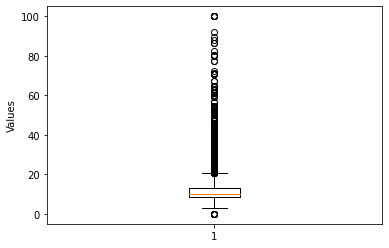

In [ ]:
plt.boxplot(df_1['sqrt_price'])


plt.ylabel('Values')

#plt.xticks(range(1, len(columns_to_plot) + 1), columns_to_plot)
plt.show()

In [ ]:
#remove names if not needed

In [ ]:
df_in['reviews_per_month'] = df_in['reviews_per_month'].fillna(0)

In [ ]:
df_in['last_review'] = pd.to_datetime(df_in['last_review'])

In [ ]:
min(df_in['last_review'])

Timestamp('2011-03-28 00:00:00')

In [ ]:
old = min(df_in['last_review'])
df_in['last_review'] = df_in['last_review'].fillna(old)
df_in['days_since_review'] = df_in['last_review'].apply(lambda x: x.toordinal() - old.toordinal())

In [ ]:
df_in['days_since_review']

0        2762
1        2976
2           0
3        3021
4        2793
         ... 
48890       0
48891       0
48892       0
48893       0
48894       0
Name: days_since_review, Length: 48895, dtype: int64

<AxesSubplot:xlabel='price', ylabel='Density'>

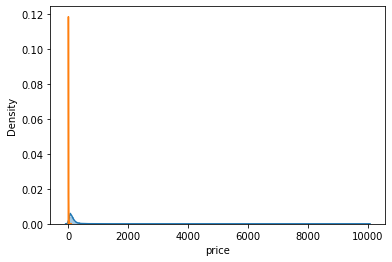

In [ ]:
sns.distplot(df_in['price'])

# axes[1].set_xlabel('log(1+price)')
# sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [ ]:
df_in.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [ ]:
#only 11 rows with no price
(df_in.price == 0).astype(int).sum()

11

<AxesSubplot:xlabel='price', ylabel='Density'>

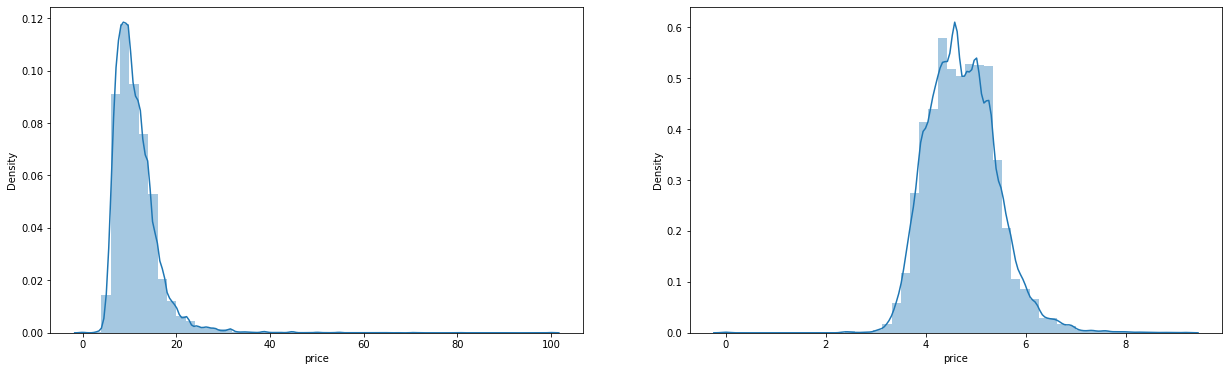

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(np.sqrt(df_in['price']), ax =axes[0])
sns.distplot(np.log1p(df_in['price']), ax = axes[1])

In [ ]:
df_in.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

<AxesSubplot:xlabel='minimum_nights', ylabel='Density'>

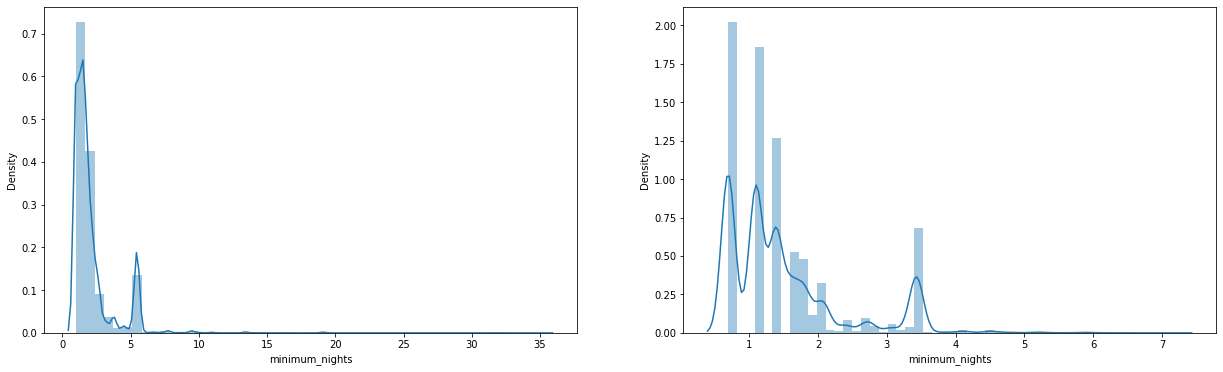

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(np.sqrt(df_in['minimum_nights']), ax =axes[0])
sns.distplot(np.log1p(df_in['minimum_nights']), ax = axes[1])

In [ ]:
df_in['price'] = np.log1p(df_in['price'])

In [ ]:
df_in['minimum_nights_log'] = np.log1p(df_in['minimum_nights'])

In [ ]:
df_in.reviews_per_month.describe()

count    48895.000000
mean         1.090910
std          1.597283
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
max         58.500000
Name: reviews_per_month, dtype: float64

<AxesSubplot:xlabel='reviews_per_month', ylabel='Density'>

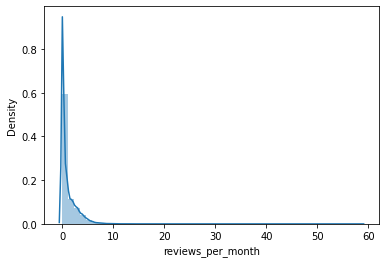

In [ ]:
sns.distplot((df_in['reviews_per_month']))

In [ ]:
df_in['reviews_per_month'] = df_in[df_in['reviews_per_month'] < 15]['reviews_per_month']

In [ ]:
df_in['year_avail'] = df_in['availability_365']>365

df_in['no_reviews'] = df_in['reviews_per_month']==0

In [ ]:
df_in.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_since_review', 'minimum_nights_log',
       'year_avail', 'no_reviews'],
      dtype='object')

In [ ]:
df_out = df_in.drop(columns=['name', 'host_name','last_review'])

In [ ]:
df_out.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'days_since_review', 'minimum_nights_log', 'year_avail', 'no_reviews'],
      dtype='object')

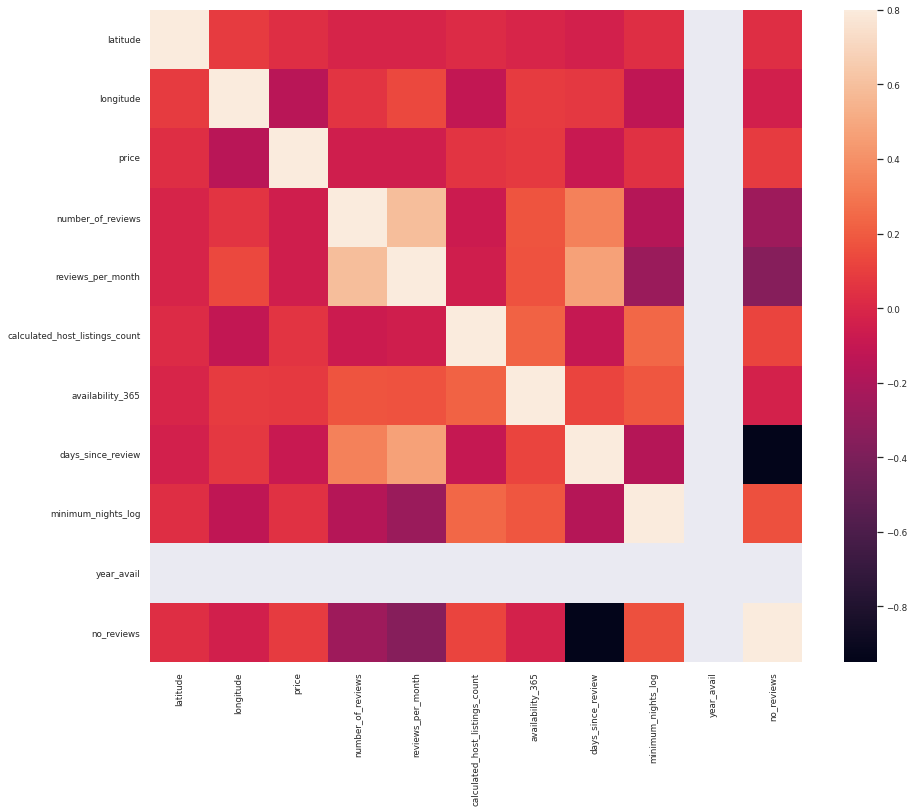

In [ ]:
corrmatrix = df_out.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

In [ ]:
df_out['reviews_per_month'] = df_out['reviews_per_month'].fillna(0)

In [ ]:
df_out.isnull().sum()

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
days_since_review                 0
minimum_nights_log                0
year_avail                        0
no_reviews                        0
dtype: int64

In [ ]:
categorical_features = df_out.select_dtypes(include=['object'])

In [ ]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
numerical_features =  df_out.select_dtypes(exclude=['object'])
price_value = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
#print('Numerical features: {}'.format(numerical_features.shape))

In [ ]:
final_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [ ]:
final_df.head(10)

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_review,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2539,2787,40.64749,-73.97237,1,9,0.21,6,365,2762,...,0,0,0,0,0,0,0,0,1,0
1,2595,2845,40.75362,-73.98377,1,45,0.38,2,355,2976,...,0,0,0,0,0,0,0,1,0,0
2,3647,4632,40.80902,-73.94190,3,0,0.00,1,365,0,...,0,0,0,0,0,0,0,0,1,0
3,3831,4869,40.68514,-73.95976,1,270,4.64,1,194,3021,...,0,0,0,0,0,0,0,1,0,0
4,5022,7192,40.79851,-73.94399,10,9,0.10,1,0,2793,...,0,0,0,0,0,0,0,1,0,0
5,5099,7322,40.74767,-73.97500,3,74,0.59,1,129,3008,...,0,0,0,0,0,0,0,1,0,0
6,5121,7356,40.68688,-73.95596,45,49,0.40,1,0,2383,...,0,0,0,0,0,0,0,0,1,0
7,5178,8967,40.76489,-73.98493,2,430,3.47,1,220,3010,...,0,0,0,0,0,0,0,0,1,0
8,5203,7490,40.80178,-73.96723,2,118,0.99,1,0,2307,...,0,0,0,0,0,0,0,0,1,0
9,5238,7549,40.71344,-73.99037,1,160,1.33,4,188,2995,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df, price_value, test_size=0.2, random_state=42)

In [ ]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39116, 242)
Dimensions of the training target vector: (39116,)
Dimensions of the test feature matrix: (9779, 242)
Dimensions of the test target vector: (9779,)


In [ ]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

In [ ]:
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [ ]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False))

In [ ]:
rfr_baseline = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


In [ ]:
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)

In [ ]:
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [ ]:
rfr_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Random Forest Regressor [baseline],0.1934,0.006837,0.026796,0.186354


In [ ]:
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

In [ ]:
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

# rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
#best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.191802,0.006209,0.076588,0.182756,0.842431,0.613696


In [ ]:
np.exp(y_test_rfr)

array([130.61167598,  57.22277479, 107.78642109, ...,  65.15921422,
       216.08214871, 123.58870835])

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_out.drop('price', axis=1), df_out['price'], test_size=0.2, random_state=42)


In [ ]:
!pip install catboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   host_id                         48895 non-null  int64         
 2   neighbourhood_group             48895 non-null  object        
 3   neighbourhood                   48895 non-null  object        
 4   latitude                        48895 non-null  float64       
 5   longitude                       48895 non-null  float64       
 6   room_type                       48895 non-null  object        
 7   price                           48895 non-null  int64         
 8   minimum_nights                  48895 non-null  int64         
 9   number_of_reviews               48895 non-null  int64         
 10  last_review                     48895 non-null  datetime64[ns]
 11  re

In [ ]:
df_out['reviews_per_month'] = df_out['reviews_per_month'].fillna(0)

In [ ]:
df_out.isnull().sum()

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
days_since_review                 0
minimum_nights_log                0
year_avail                        0
no_reviews                        0
dtype: int64

In [ ]:
cb = CatBoostRegressor(n_estimators=1000,
                       loss_function='RMSE',
                       learning_rate=0.01,
                       depth=8, task_type='CPU',
                       random_state=1,
                       verbose=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_out.drop('price', axis=1), df_out['price'], test_size=0.2, random_state=42)

In [ ]:
pool_train = Pool(X_train, y_train,
                  cat_features = ['neighbourhood_group', 'neighbourhood','room_type'])

pool_test = Pool(X_test, cat_features = ['neighbourhood_group', 'neighbourhood','room_type'])

In [ ]:
cb.fit(pool_train)
y_pred = cb.predict(pool_test)

In [ ]:
y_test_final = np.exp(y_test)

y_pred_final = np.exp(y_pred)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-76-ebcd0fdd8220>:3: RuntimeWarning: overflow encountered in exp
  y_pred_final = np.exp(y_pred)


R-squared: 0.2302
RMSE: 184.5409


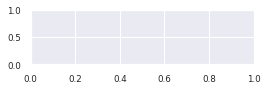

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as mse

# Evaluate the model performance
r_squared = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the evaluation metrics
print("R-squared: {:.4f}".format(r_squared))
print("RMSE: {:.4f}".format(rmse))